In [89]:
# Create a plot that shows examples of various benchmarks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [3]:
# Load Qobs and all the benchmark sims
qobs_file = Path('./timeseries/hysets_08NB014.csv')
qsim_file = Path('./benchmarks/hysets_08NB014.csv')

qobs = pd.read_csv(qobs_file, index_col=0, parse_dates=True)
qsim = pd.read_csv(qsim_file, index_col=0, parse_dates=True)

In [166]:
# Get the scores
score_file = Path('benchmark_scores_summary.csv')
scores = pd.read_csv(score_file, index_col=[0, 1])

idx = pd.IndexSlice
basin_kges = scores.loc[ idx[['kge_cal','kge_val'], 'hysets_08NB014'], :]

In [21]:
# Replicate the cal/val split
flow_mask = qobs['streamflow'] >= 0
flow_dates = flow_mask.index
median_date = flow_dates[len(flow_dates) // 2]

# Specify the calculation and evaluation periods, as boolean masks
cal_mask = qobs.index <= median_date
val_mask = ~cal_mask 

In [90]:
# Replicate the rain_plus_melt flux
def rain_to_melt(
    data, precipitation="precipitation", temperature="temperature", snow_and_melt_temp=0.0, snow_and_melt_rate=3.0
):
    """Calculate snow accumulation and melt based on temperature thresholds.

    Parameters
    ----------
    data : pandas DataFrame
        Input data containing precipitation and temperature columns.
    precipitation : str, optional
        Name of the precipitation column in the input data. Default is 'precipitation'.
    temperature : str, optional'
        Name of the temperature column in the input data. Default is 'temperature'.
    snow_and_melt_temp : float, optional
        Temperature threshold for snow accumulation and melt. Default is 0.0 [C].
    snow_and_melt_rate : float, optional
        Snow melt rate if temperature above threshold. Default is 3.0 [mm/hour/degree C].

    Returns
    -------
    data : pandas DataFrame
        Input data with additional colu"mns for snow depth and rain plus melt.
    """

    # Docs: 3 degrees C is a conservative estimate (see e.g.: https://tc.copernicus.org/articles/17/211/2023/)

    # Check that melt rate is not negative
    if snow_and_melt_rate < 0:
        raise ValueError(f"Snow melt rate must be non-negative. Currently set to: {snow_and_melt_rate}.")

    # Run a really simple time-stepping scheme to account for snow accumulation and melt.
    # We'll deal with the time step implicitly, simply assuming that delta t = 1.
    # We can get away with Explicit Euler (Snew = Sold + snowfall - snowmelt) because fall
    # and melt are mutually exclusive: no problems with ad-hoc operator splitting here.
    snow_depth = []
    rain_plus_melt = []
    Sold = 0
    for _, row in data.iterrows():
        # Determine snowfall or melt
        if row[temperature] > snow_and_melt_temp:
            melt = np.min([Sold, snow_and_melt_rate * (row[temperature] - snow_and_melt_temp)])
            rain = row[precipitation]
            snow = 0
        else:
            melt = 0
            rain = 0
            snow = row[precipitation]

        # Update the snow pack
        Snew = Sold + snow - melt

        # Retain the values
        snow_depth.append(Snew)
        rain_plus_melt.append(rain + melt)

        # Prepare for the next time step
        Sold = Snew

    # Outputs
    data["snow_depth"] = snow_depth
    data["rain_plus_melt"] = rain_plus_melt

    return data

qobs = rain_to_melt(qobs, precipitation='total_precipitation_sum', temperature='temperature_2m_mean')

In [176]:
basin_kges

,,mean_flow,median_flow,monthly_mean_flow,monthly_median_flow,daily_mean_flow,daily_median_flow,rainfall_runoff_ratio_to_all,rainfall_runoff_ratio_to_annual,rainfall_runoff_ratio_to_monthly,rainfall_runoff_ratio_to_daily,rainfall_runoff_ratio_to_timestep,monthly_rainfall_runoff_ratio_to_monthly,monthly_rainfall_runoff_ratio_to_daily,monthly_rainfall_runoff_ratio_to_timestep,scaled_precipitation_benchmark,adjusted_precipitation_benchmark,adjusted_smoothed_precipitation_benchmark
metric,basin,,,,,,,,,,,,,,,,,
kge_cal,hysets_08NB014,NaN,NaN,0.820636,0.769725,0.853586,0.813723,-0.414214,-0.332556,0.59748,0.203190,0.203190,0.726197,-0.145814,-0.145814,0.203190,0.209218,0.820047
kge_val,hysets_08NB014,-0.414221,-0.580138,0.849259,0.799530,0.875609,0.838693,-0.414214,-0.323225,0.50131,0.120558,0.120558,0.686807,-0.276736,-0.276736,0.120558,0.128237,0.843016


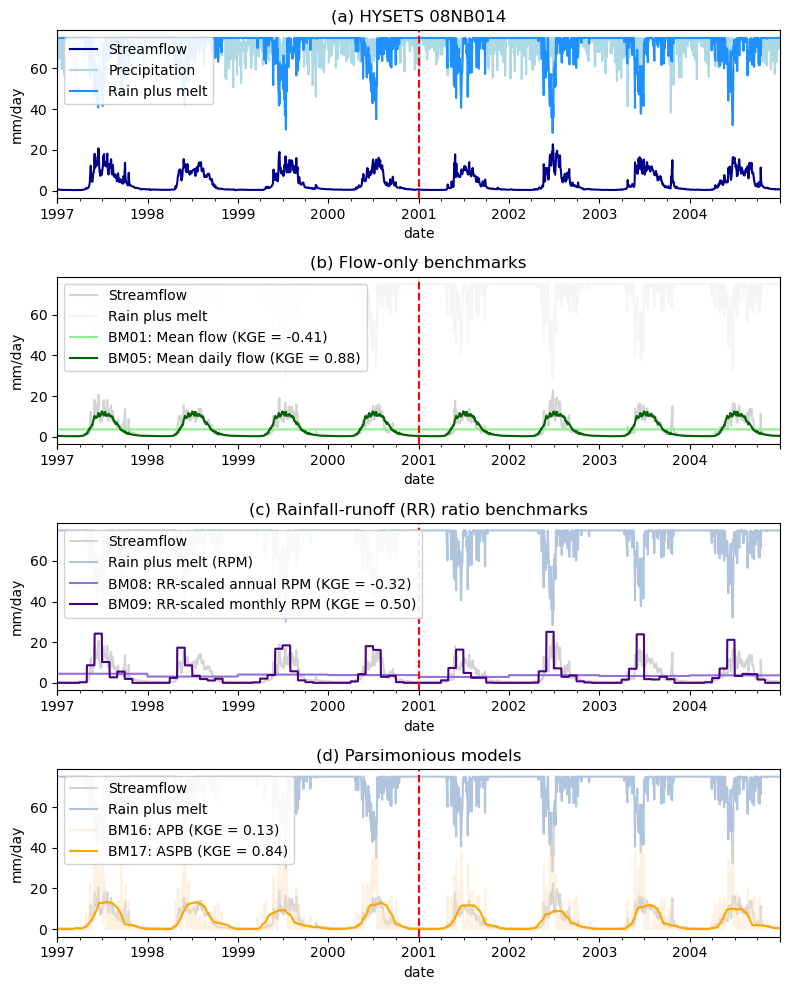

In [179]:
fig, axs = plt.subplots(4,1,figsize=(8,10))

# General settings
leg_loc = 'upper left'
leg_alpha = .9
n = 4
xlims = [median_date - pd.DateOffset(years=n), median_date + pd.DateOffset(years=n)]

# Data
ax = axs[0]
qobs['streamflow'].plot(ax=ax, label='Streamflow', color='darkblue')
(75-qobs['total_precipitation_sum']).plot(ax=ax, label='Precipitation', color='lightblue')
(75-qobs['rain_plus_melt']).plot(ax=ax, label='Rain plus melt', color='dodgerblue')
ax.axvline(median_date, color='r', linestyle='--')
ax.legend(loc=leg_loc, framealpha=leg_alpha)
ax.set_title('(a) HYSETS 08NB014')
ax.set_ylabel('mm/day')
ax.set_xlim(xlims)

# Q-only benchmarks
val1 = basin_kges['mean_flow'].kge_val.values[0]
val2 = basin_kges['daily_mean_flow'].kge_val.values[0]
lbl1 = f'BM01: Mean flow (KGE = {val1:.2f})'
lbl2 = f'BM05: Mean daily flow (KGE = {val2:.2f})'

ax = axs[1]
qobs['streamflow'].plot(ax=ax, label='Streamflow', color='lightgrey')
(75-qobs['rain_plus_melt']).plot(ax=ax, label='Rain plus melt', color='whitesmoke')
qsim['bm_mean_flow'].plot(ax=ax, label=lbl1, color='lightgreen')
qsim['bm_daily_mean_flow'].plot(ax=ax, label=lbl2, color='darkgreen')
ax.axvline(median_date, color='r', linestyle='--')
ax.legend(loc=leg_loc, framealpha=leg_alpha)
ax.set_title('(b) Flow-only benchmarks')
ax.set_ylabel('mm/day')
ax.set_xlim(xlims)

# RR-benchmarks
val1 = basin_kges['rainfall_runoff_ratio_to_annual'].kge_val.values[0]
val2 = basin_kges['rainfall_runoff_ratio_to_monthly'].kge_val.values[0]
lbl1 = f'BM08: RR-scaled annual RPM (KGE = {val1:.2f})'
lbl2 = f'BM09: RR-scaled monthly RPM (KGE = {val2:.2f})'

ax = axs[2]
qobs['streamflow'].plot(ax=ax, label='Streamflow', color='lightgrey')
(75-qobs['rain_plus_melt']).plot(ax=ax, label='Rain plus melt (RPM)', color='lightsteelblue')
qsim['bm_rainfall_runoff_ratio_to_annual'].plot(ax=ax, label=lbl1, color='mediumpurple')
qsim['bm_rainfall_runoff_ratio_to_monthly'].plot(ax=ax, label=lbl2, color='indigo')
ax.axvline(median_date, color='r', linestyle='--')
ax.legend(loc=leg_loc, framealpha=leg_alpha)
ax.set_title('(c) Rainfall-runoff (RR) ratio benchmarks')
ax.set_ylabel('mm/day')
ax.set_xlim(xlims)

# Calibrated benchmarks
val1 = basin_kges['adjusted_precipitation_benchmark'].kge_val.values[0]
val2 = basin_kges['adjusted_smoothed_precipitation_benchmark'].kge_val.values[0]
lbl1 = f'BM16: APB (KGE = {val1:.2f})'
lbl2 = f'BM17: ASPB (KGE = {val2:.2f})'

ax = axs[3]
qobs['streamflow'].plot(ax=ax, label='Streamflow', color='lightgrey')
(75-qobs['rain_plus_melt']).plot(ax=ax, label='Rain plus melt', color='lightsteelblue')
qsim['bm_adjusted_precipitation_benchmark'].plot(ax=ax, label=lbl1, color='bisque', alpha=0.5)
qsim['bm_adjusted_smoothed_precipitation_benchmark'].plot(ax=ax, label=lbl2, color='orange')
ax.axvline(median_date, color='r', linestyle='--')
ax.legend(loc=leg_loc, framealpha=leg_alpha)
ax.set_title('(d) Parsimonious models')
ax.set_ylabel('mm/day')
ax.set_xlim(xlims)

plt.tight_layout()
file_name = Path('./paper_plots/benchmark_example.png')
plt.savefig(file_name, bbox_inches='tight', dpi=300)